In [1]:
%%time
#importar galeries
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import units
import seaborn as sns

#Valors a canviar al canviar d'any:
estació="Albuquerque"
any=2022
dies_febrer=28
excel=openpyxl.load_workbook("2022_tfg_Albuquerque.xlsx")#obrim l'excel

Wall time: 30 s


In [2]:
%%time
#vull agafar valors de THTA i altura a 700hPa (servirà per NCE)

#llistes per després navegar per l'excel
dies=["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16"
      ,"17","18","19","20","21","22","23","24","25","26","27","28","29","30","31"]
mesos=["gener","febrer","març","abril","maig","juny","juliol","agost"
       ,"setembre","octubre","novembre","desembre"]
mesos_31dies=["gener","març","maig","juliol","agost","octubre","desembre"]
mesos_30dies=["abril","juny","setembre","novembre"]
ab=[" Jan"," Fe"," Ma"," Apr"," May"," Ju"," Ju"," Au"," Se"," Oc"," No"," De"]

#creo l'arrays on posaré els valors de THTA i altura a 700 hPa 
THTA_00_700 = np.full(366, np.nan)
THTA_00_700[0] = 700
altura_700 = np.full(366, np.nan)
altura_700[0] = 700

#un array per valors entre 750 i 800. Per cada dia es prendran els valors d'entre 750 i 800 hPa i s'afegirà la mitjana en aquest array.
THTA_00_750_800 = np.full(366, np.nan)
THTA_00_750_800[0] = np.nan
press750800=np.arange(750.0,800.0,step=1.0)

b=0#aquest valor indicarà la columna a la que pertoca el valor d'aquell dia

for mes in mesos:#una iteració per cada mes/full de l'excel
    #print(mes)
    full=excel[mes]#agafem el full de l'excel del mes que fem
    columna=full["G"]#la columna de l'excel on hi ha indicat l'hora i el dia de la mesura
    col_press=full["B"]#la columna de l'excel amb les pressions
    
    #el valor dimes serà el nombre de dies que té el mes que toca
    if mes in mesos_31dies:
        dimes=31
    elif mes in mesos_30dies:
        dimes=30
    elif mes=="febrer":
        dimes=dies_febrer
    
    fsegüent=9#perqué no comneçi a mirar el primer dia en una fila negativa
    for i in np.arange(0,dimes):#m'ha semblat que teniem pocs loops, així que un amb una iteració per dia del mes
        #print(dies[i],"dia")
        
        valorsTHTA_750800=[]#valors del dia i hora de la temperatura dins l'interval (el buidem per posar els d'aquest dia)

        b+=1#aquest valor marca la columna on colocarà la dada dels nostres arrays amb dades
        for fila in range(fsegüent-8, full.max_row + 1):#loop amb una iteració per cela de la columna amb l'hora i el dia
            
            #en aquestes posicións mirarà si hi ha algo que indiqui que estem en el dia que volem
            celda = full["G" + str(fila)]
            celda2 = full["H" + str(fila)]
            
            #aquestes són les diferents maneres en que l'excel ens pot indicar el dia
            string_nit="00Z "+dies[i]#l'string que trobarem en l'excel per indicar aquell dia a les 00 de la nit
            string_nit2="t 00Z "+dies[i]#el mateix en altres mesos
            string_nit3="at 00Z"
            string_nit3c2=dies[i]+ab[mesos.index(mes)]
            
            #un cop trobem la casella en que indica el dia que busquem:
            if celda.value==string_nit or celda.value==string_nit2 or (celda.value==string_nit3 and celda2.value==string_nit3c2) or celda2.value==string_nit:#si a la cela hi ha aquesta string           

                c, f=openpyxl.utils.cell.coordinate_from_string(celda.coordinate)#pren la columna i fila de la cela indicant l'hora i el dia
                #ara que tenim la cela volem mirar fins on acaben les dades d'aquella hora i dia
                for fila in np.arange(f+10,f+300):#busquem en aquestes files
                    if full.cell(row=fila, column=openpyxl.utils.column_index_from_string("B")).value=="1000.0":#busquem la fila amb el valor 1000.0 de la següent mesura
                        fsegüent=fila#ens apuntem la fila
                        break
                #ara sabem que les mesures d'aquella hora i dia estan entre la fila "f" i la fila "fsegüent"
                
                for fil in np.arange(f,fsegüent):#ara fem un loop per mirar cada fila de només aquesta mesura
                    cell=full.cell(row=fil, column=openpyxl.utils.column_index_from_string("B"))
                    #mirem la cela de columna de les pressions i fila de la iteració
                    if cell.value=="700.0":#a veure si hi ha la pressió que busquem
                        cv, fv=openpyxl.utils.cell.coordinate_from_string(cell.coordinate)
                        #apuntem columna i fila de la cela amb la pressió que buscavem
                        pTHTA=openpyxl.utils.cell.get_column_letter(10) + str(fv)#coordenada de la THTA
                        palt=openpyxl.utils.cell.get_column_letter(3) + str(fv)#coordenada de la altura
                        if isinstance(full[pTHTA].value, str):#si el valor està presentable per l'amor de Déu
                            THTA_00_700[b]=float(full[pTHTA].value)#ens apuntem el valor en el nostre arrays de dades
                            altura_700[b]=float(full[palt].value)#ens apuntem el valor de l'altura també
                            
                            
                    if cell.value in np.array(press750800, dtype=str):
                        #a veure si hi ha una pressió entre 750 i 800 en aquella fila
                        cv2, fv2=openpyxl.utils.cell.coordinate_from_string(cell.coordinate)
                        #apuntem columna i fila de la cela amb la pressió que buscavem
                        pTHTA2=openpyxl.utils.cell.get_column_letter(10) + str(fv2)#coordenada de la THTA
                        if isinstance(full[pTHTA2].value, str):#si el valor està presentable per l'amor de Dé
                            valorsTHTA_750800=np.append(valorsTHTA_750800, float(full[pTHTA2].value))#ens apuntem el valor          
        
        #després de mirar el dia sencer fem mitjana dels valors d'entre 750 i 800 que hem pres i l'apuntem al nostre array
        THTA_00_750_800[b]=np.nanmean(np.array(valorsTHTA_750800, dtype=float))
        


C:\Users\emmas\miniconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice


Wall time: 55.7 s


In [3]:
#radios

#%%time
#en aquesta cela agafarem els valors de l'excel d'algunes pressions

#arrays amb els valors dels dies les pressions i els mesos
dies=["01","02","03","04","05","06","07","08","09","10","11","12","13"
      ,"14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","31"]
pressions=["700.0","500.0","400.0","300.0","200.0","150.0","100.0","50.0","30.0","20.0"]
mesos=["gener","febrer","març","abril","maig","juny","juliol","agost","setembre"
       ,"octubre","novembre","desembre"]
mesos_31dies=["gener","març","maig","juliol","agost","octubre","desembre"]
mesos_30dies=["abril","juny","setembre","novembre"]
ab=[" Jan"," Fe"," Ma"," Apr"," May"," Ju"," Ju"," Au"," Se"," Oc"," No"," De"]
a_final=[]#aixó ens servirà per després afegir els valors dels mesos que no fem aquí
dates_00=[]
dates_12=[]
GR=[]#quants es guarden valors als arrays per graficar
bib=[]#de quants dies s'en miren les dades

num_pressions=len(pressions)#número de pressions que treballem

#fem matrius on hi colocarem els valors de temperatura, temperatura de rosada, humitat relativa i mixr de cada pressió
num_valors=800
#en aquests arrays hi posaré els valor pensats per fer la mitjana sense 0 ni nan que puguin alterar-la:
dades_temp_00=np.zeros((num_pressions,num_valors))
dades_tempros_00=np.zeros((num_pressions,num_valors))
dades_humrel_00=np.zeros((num_pressions,num_valors))
dades_mixr_00=np.zeros((num_pressions,num_valors))
#aquest és l'array per graficar que esta pensat perqué
#tingui un valor per cada dia i cada valor en la posició corresponent del dia de l'any
#si un dia no té valor se li posa nan:
dades_temp_00_graf=np.zeros((num_pressions,num_valors))


dades_temp_12=np.zeros((num_pressions,num_valors))
dades_tempros_12=np.zeros((num_pressions,num_valors))
dades_humrel_12=np.zeros((num_pressions,num_valors))
dades_mixr_12=np.zeros((num_pressions,num_valors))

dades_temp_12_graf=np.zeros((num_pressions,num_valors))

#el primer valor que guardarem a cada fila serà el de la pressió del que se'n diuen valors en aquella fila per no perdre'ns
for i in np.arange(0,num_pressions):
    dades_temp_00_graf[i][0]=pressions[i]
    dades_temp_00[i][0]=pressions[i]
    dades_tempros_00[i][0]=pressions[i]
    dades_humrel_00[i][0]=pressions[i]
    dades_mixr_00[i][0]=pressions[i]

    dades_temp_12_graf[i][0]=pressions[i]
    dades_temp_12[i][0]=pressions[i]
    dades_tempros_12[i][0]=pressions[i]
    dades_humrel_12[i][0]=pressions[i]
    dades_mixr_12[i][0]=pressions[i]

print("1")
for pres in np.arange(0,num_pressions):#aquí fem un loop amb una iteració per cada pressió que estudiem
    bibo=0
    a=0
    a12=0
    b=0
    gr=0#marca on es colocaran els valors per graficar de manera que cada dia tingui un valor (per les 00 de la nit)
    gr12=0#el mateix però per les 12 del migdia
    for mes in mesos:#fem-ne un altre amb una iteració per cada mes/full de l'excel
      
        full=excel[mes]#agafem el full de l'excel del mes que fem
        columna=full["G"]#la columna de l'excel on hi ha indicat l'hora i el dia de la mesura
        columna2=full["H"]
        col_press=full["B"]#la columna de l'excel amb les pressions


        if mes in mesos_31dies:
            dimes=31
        elif mes in mesos_30dies:
            dimes=30
        elif mes=="febrer":
            dimes=dies_febrer
        fsegüent=9
        for i in np.arange(0,dimes):#m'ha semblat que teniem pocs loops, així que un amb una iteració per dia del mes
         
            bibo+=1
            u=0
            v=0

           
    #aniria tot mes ràpid si en contes de full.max_raw 1 posses un número molt gros però no tant
            for fila in range(fsegüent-8, full.max_row + 1):#loop amb una iteració per cela de la columna amb l'hora i el dia
                #print(fila, "fila")
                celda = full["G" + str(fila)]
                celda2 = full["H" + str(fila)]
                
                #aquí faré per les 12 de la nit
                string_nit="00Z "+dies[i]#l'string que trobarem en l'excel per indicar aquell dia a les 00 de la nit
                string_nit2="t 00Z "+dies[i]#el mateix en altres mesos
                string_nit3="at 00Z"

                string_nit3c2=dies[i]+ab[mesos.index(mes)]

                if celda.value==string_nit or celda.value==string_nit2 or (celda.value==string_nit3 and celda2.value==string_nit3c2) or celda2.value==string_nit:#si a la cela hi ha aquesta string

                    u=1
                    #print(celda.value)
                    c, f=openpyxl.utils.cell.coordinate_from_string(celda.coordinate)#pren la columna i fila de la cela indicant l'hora i el dia
                    #ara que tenim la cela volem mirar fins on acaben les dades d'aquella hora i dia
                    for fila in np.arange(f+10,f+300):#busquem en aquestes files
                        if full.cell(row=fila, column=openpyxl.utils.column_index_from_string("B")).value=="1000.0":#busquem la fila amb el valor 1000.0 de la següent mesura
                            fsegüent=fila#ens apuntem la fila
                            #print(fsegüent,"fsegüent")
                            break


                    e=a
                    for fil in np.arange(f,fsegüent):#ara fem un loop per mirar cada fila de només aquesta mesura
                        cell=full.cell(row=fil, column=openpyxl.utils.column_index_from_string("B"))#mirem la cela de columna de les pressions i fila de la iteració
                        if cell.value==pressions[pres]:#a veure si hi ha la pressió que busquem
                            gr+=1
                            a+=1#aquest valor marca la columna on colocarà la dada dels nostres arrays amb dades
                            cv, fv=openpyxl.utils.cell.coordinate_from_string(cell.coordinate)#apuntem columna i fila de la cela amb la pressió que buscavem
                            #d'aquella fila/pressió prendrem els valors de les columnes amb la temperatura, la temperatura de rosada, la humitat relativa i el mixr
                            pT=openpyxl.utils.cell.get_column_letter(4) + str(fv)#coordenada de la tempertura
                            if isinstance(full[pT].value, str):#si el valor està presentable per l'amor de Déu
                                dades_temp_00[pres][a]=float(full[pT].value)#ens apuntem el valor en el nostre arrays de dades
                                dades_temp_00_graf[pres][gr]=float(full[pT].value)
                            #fem el mateix per la temperatura de rosada, humitat relativa i mixr:
                            pTr=openpyxl.utils.cell.get_column_letter(5) + str(fv)
                            if isinstance(full[pTr].value, str):
                                dades_tempros_00[pres][a]=float(full[pTr].value)

                            phr=openpyxl.utils.cell.get_column_letter(6) + str(fv)
                            if isinstance(full[phr].value, str) or isinstance(full[phr].value, int):
                                dades_humrel_00[pres][gr]=float(full[phr].value)

                            pmixr=openpyxl.utils.cell.get_column_letter(7) + str(fv)
                            if isinstance(full[pmixr].value, str):
                                dades_mixr_00[pres][a]=float(full[pmixr].value)
                            break

                    if a==e:#si pasa això el valor d'a no ha canviat i no s'ha trobat mesures d'aquell dia en aquella pressió
                        gr+=1
                        dades_temp_00_graf[pres][gr]=np.nan
                        dades_humrel_00[pres][gr]=np.nan
                        dades_tempros_00[pres][gr]=np.nan
                        



                #aquí faré per les 12 del dia
                string_dia="12Z "+dies[i]
                string_dia2="t 12Z "+dies[i]
                string_dia3="at 12Z"
                string_nit3c2=dies[i]+ab[mesos.index(mes)]
                if celda.value==string_dia or celda.value==string_dia2 or (celda.value==string_dia3 and celda2.value==string_nit3c2) or celda2.value==string_dia:
                    v=1
                    #print(celda.value)
                    c, f=openpyxl.utils.cell.coordinate_from_string(celda.coordinate)#pren la columna i fila de la cela indicant l'hora i el dia
                    #ara que tenim la cela volem mirar fins on acaben les dades d'aquella hora i dia
                    for fila in np.arange(f+10,f+300):#busquem en aquestes files
                        if full.cell(row=fila, column=openpyxl.utils.column_index_from_string("B")).value=="1000.0":#busquem la fila amb el valor 1000.0 de la següent mesura
                            fsegüent=fila#ens apuntem la fila
                            break

                    e12=b
                    for fil in np.arange(f,fsegüent):#ara fem un loop per mirar cada fila de només aquesta mesura
                        cell=full.cell(row=fil, column=openpyxl.utils.column_index_from_string("B"))#mirem la cela de columna de les pressions i fila de la iteració
                        if cell.value==pressions[pres]:#a veure si hi ha la pressió que busquem
                            gr12+=1
                            b+=1#aquest valor marca la columna on colocarà la dada dels nostres arrays amb dades
                            cv, fv=openpyxl.utils.cell.coordinate_from_string(cell.coordinate)#apuntem columna i fila de la cela amb la pressió que buscavem
                            #d'aquella fila/pressió prendrem els valors de les columnes amb la temperatura, la temperatura de rosada, la humitat relativa i el mixr
                            pT=openpyxl.utils.cell.get_column_letter(4) + str(fv)#coordenada de la tempertura
                            if isinstance(full[pT].value, str):#si el valor està presentable per l'amor de Déu
                                dades_temp_12[pres][b]=float(full[pT].value)#ens apuntem el valor en el nostre arrays de dades
                                dades_temp_12_graf[pres][gr12]=float(full[pT].value)
                            #fem el mateix per la temperatura de rosada, humitat relativa i mixr:
                            pTr=openpyxl.utils.cell.get_column_letter(5) + str(fv)
                            if isinstance(full[pTr].value, str):
                                dades_tempros_12[pres][b]=float(full[pTr].value)

                            phr=openpyxl.utils.cell.get_column_letter(6) + str(fv)
                            if isinstance(full[phr].value, str) or isinstance(full[phr].value, int):
                                dades_humrel_12[pres][gr12]=float(full[phr].value)

                            pmixr=openpyxl.utils.cell.get_column_letter(7) + str(fv)
                            if isinstance(full[pmixr].value, str):
                                dades_mixr_12[pres][b]=float(full[pmixr].value)
                            break
                    if b==e12:#si pasa això el valor d'b no ha canviat i no s'ha trobat mesures d'aquell dia en aquella pressió
                        gr12+=1
                        dades_temp_12_graf[pres][gr12]=np.nan
                        dades_humrel_12[pres][gr12]=np.nan
                    break
            if u==0:#si passa això el valor de u no ha canviat i, per tant, no hi ha mesures d'aquest dia i hora
                #en aquest if possem un valor en el array a graficar perquè segueixi anant en ordre i cada dia estigui en el seu índex corresponent
                gr+=1
                dades_temp_00_graf[pres][gr]=np.nan
                dades_humrel_00[pres][gr]=np.nan
                dades_tempros_00[pres][gr]=np.nan
            if v==0:#si passa això el valor de u no ha canviat i, per tant, no hi ha mesures d'aquest dia i hora
                #en aquest if possem un valor en el array a graficar perquè segueixi anant en ordre i cada dia estigui en el seu índex corresponent
                gr12+=1
                dades_temp_12_graf[pres][gr12]=np.nan
                dades_humrel_12[pres][gr12]=np.nan
    bib=np.append(bib,bibo)
    GR=np.append(GR,gr)
print("quants es guarden valors als arrays per graficar:",GR)
print("de quants dies s'en miren les dades:", bib)

1
quants es guarden valors als arrays per graficar: [365. 365. 365. 365. 365. 365. 365. 365. 365. 365.]
de quants dies s'en miren les dades: [365. 365. 365. 365. 365. 365. 365. 365. 365. 365.]


In [5]:
#construim l'array que ens farà d'eix x amb els dies de l'any:
dates_00=[]
dies_mesos=[0,]
a=0
for mes in mesos:
    if mes in mesos_31dies:
        dimes=31
    elif mes in mesos_30dies:
        dimes=30
    elif mes=="febrer":
        dimes=dies_febrer
    for i in np.arange(0,dimes):
        dates_00.append(mes + " " + dies[i])#per fer l'eix X de les gràfiques amb cada dia
    a+=dimes
    dies_mesos=np.append(dies_mesos,a)
print(dies_mesos)

[  0  31  59  90 120 151 181 212 243 273 304 334 365]


(365,) (365,)


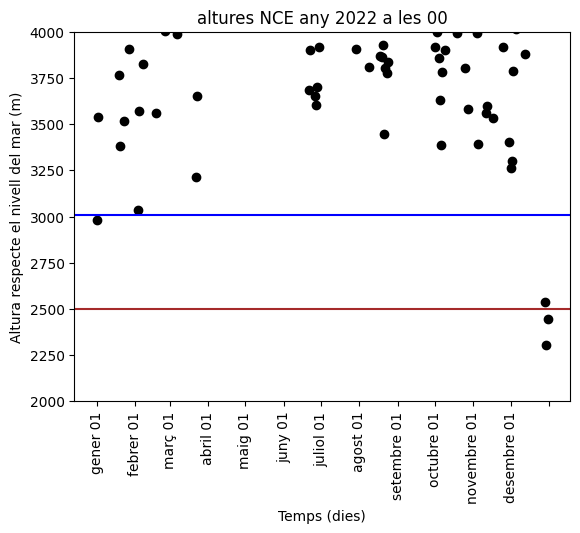

['gener 01' 'febrer 03' 'març 22' 'desembre 29' 'desembre 30'
 'desembre 31']
[  0  33  80 362 363 364]


In [6]:
#NCE

#aquí calculem la altura del NCE utilitzant la fòrmula de schuver (crec que s'escriu així)

z_NCE=altura_700[1:] + ((6/5)*(dades_temp_00_graf[0][1:366]-dades_tempros_00[0][1:366]))*100
print(np.shape(z_NCE),np.shape(dates_00))

plt.scatter(dates_00, z_NCE, color="k")
plt.ylim(2000, 4000)
plt.axhline(y=3007, color="b")
plt.axhline(y=2500, color="brown")

plt.title(f"altures NCE any {any} a les 00")
plt.xticks(dies_mesos,rotation=90)
plt.ylabel("Altura respecte el nivell del mar (m)")
plt.xlabel("Temps (dies)")
plt.show()


dates_3250 = np.array(dates_00)[z_NCE < 3250]
print(dates_3250)
pos_3250=np.where(z_NCE<3250)[0]
print(pos_3250)

In [7]:
#NCE

#aquí miro en quines posicions estan els NCE més baixos
posNCE_3500 = np.where(z_NCE < 3500)
print(posNCE_3500)

posNCE_3000_2500 = np.where ((3000 > z_NCE) & (z_NCE > 2500))
print(posNCE_3000_2500[0])
print(z_NCE[posNCE_3000_2500])
#print(np.array(dates_00)([125,158]))
print(z_NCE[158])

(array([  0,  19,  33,  80, 232, 278, 308, 333, 334, 335, 362, 363, 364],
      dtype=int64),)
[  0 362]
[2983. 2536.]
5526.0
